In [ ]:
import shutil
from pathlib import Path
from typing import Any
import pandas as pd
!pip install logzero
from logzero import logger
from tqdm.auto import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Pre cleaning
ARTICLES_ORIGINAL = {
    'article_id': 'object',
    'product_code': 'int64',
    'prod_name': 'object',
    'product_type_no': 'int64',
    'product_type_name': 'object',
    'product_group_name': 'object',
    'graphical_appearance_no': 'int64',
    'graphical_appearance_name': 'object',
    'colour_group_code': 'int64',
    'colour_group_name': 'object',
    'perceived_colour_value_id': 'int64',
    'perceived_colour_value_name': 'object',
    'perceived_colour_master_id': 'int64',
    'perceived_colour_master_name': 'object',
    'department_no': 'int64',
    'department_name': 'object',
    'index_code': 'object',
    'index_name': 'object',
    'index_group_no': 'int64',
    'index_group_name': 'object',
    'section_no': 'int64',
    'section_name': 'object',
    'garment_group_no': 'int64',
    'garment_group_name': 'object',
    'detail_desc': 'object',
}

CUSTOMERS_ORIGINAL = {
    'customer_id': 'object',
    'FN': 'float64',
    'Active': 'float64',
    'club_member_status': 'object',
    'fashion_news_frequency': 'object',
    'age': 'float64',
    'postal_code': 'object',
}

TRANSACTIONS_ORIGINAL = {
    'customer_id': 'object',
    'article_id': 'object',
    'price': 'float64',
    'sales_channel_id': 'int64',
}

data_dir = '/content/drive/MyDrive/CIS520-Final Project'

def _count_encoding_dict(df, col_name):
    v = df.groupby(col_name).size().reset_index(name='size').sort_values(by='size', ascending=False)[col_name].tolist()
    return {x: i for i, x in enumerate(v)}

def _dict_to_dataframe(mp):
    return pd.DataFrame(mp.items(), columns=['val', 'idx'])

def _add_idx_column(df, col_name_from, col_name_to, mp):
    df[col_name_to] = df[col_name_from].apply(lambda x: mp[x]).astype('int64')

articles = pd.read_csv(f'{data_dir}/articles.csv', dtype=ARTICLES_ORIGINAL) 
customers = pd.read_csv(f'{data_dir}/customers.csv', dtype=CUSTOMERS_ORIGINAL) 
transactions = pd.read_csv(
    f'{data_dir}/transactions_train.csv',
    dtype=TRANSACTIONS_ORIGINAL,
    parse_dates=['t_dat'] 
)

_count_encoding_dict(customers, 'club_member_status')

logger.info("start processing customers")

# (None, 1) -> (0, 1)
customers['FN'] = customers['FN'].fillna(0).astype('int64') 
customers['Active'] = customers['Active'].fillna(0).astype('int64') 

customers['club_member_status'] = customers['club_member_status'].fillna('NULL') 
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('NULL') 

for col_name in ['club_member_status', 'fashion_news_frequency',]:
    mp = _count_encoding_dict(customers, col_name)
    _add_idx_column(customers, col_name, f'{col_name}_idx', mp) 
customers.to_pickle(f'{data_dir}/users.pkl') 


logger.info("start processing articles")

count_encoding_columns = [
    'product_type_no',
    'product_group_name',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no',
]
for col_name in count_encoding_columns:
    mp = _count_encoding_dict(articles, col_name)
    _add_idx_column(articles, col_name, f'{col_name}_idx', mp)
articles.to_pickle(f'{data_dir}/items.pkl') 


logger.info("start processing transactions")

transactions['week'] = (transactions['t_dat'].max() - transactions['t_dat']).dt.days // 7
transactions.to_pickle(f'{data_dir}/transactions_train.pkl') 

[I 221213 13:56:56 <ipython-input-3-2accae0e291a>:69] start processing customers
[I 221213 13:57:01 <ipython-input-3-2accae0e291a>:84] start processing articles
[I 221213 13:57:03 <ipython-input-3-2accae0e291a>:105] start processing transactions


In [ ]:
articles = pd.read_pickle(f'{data_dir}/items.pkl') 
customers = pd.read_pickle(f'{data_dir}/users.pkl') 
transactions = pd.read_pickle(f'{data_dir}/transactions_train.pkl')

In [ ]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,product_group_name_idx,graphical_appearance_no_idx,colour_group_code_idx,perceived_colour_value_id_idx,perceived_colour_master_id_idx,department_no_idx,index_code_idx,index_group_no_idx,section_no_idx,garment_group_no_idx
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,0,0,0,0,0,7,0,0,30,2
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,0,0,2,2,2,7,0,0,30,2
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,0,3,11,1,2,7,0,0,30,2
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,4,0,0,0,0,155,7,0,5,4
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,4,0,2,2,2,155,7,0,5,4


In [ ]:
articles['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Underwear/nightwear', 'Shoes', 'Swimwear',
       'Garment Full body', 'Cosmetic', 'Interior textile', 'Bags',
       'Furniture', 'Garment and Shoe care', 'Fun', 'Stationery'],
      dtype=object)

In [ ]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,club_member_status_idx,fashion_news_frequency_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,0,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,0,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,0,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,0,1


In [ ]:
customers = customers[['customer_id','FN', 'Active','age','club_member_status_idx', 'fashion_news_frequency_idx']]
customers.head()

,customer_id,FN,Active,age,club_member_status_idx,fashion_news_frequency_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,49.0,0,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,25.0,0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,24.0,0,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,54.0,0,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,52.0,0,1


In [ ]:
articles = articles[['article_id','product_type_no_idx', 'product_group_name_idx',
       'graphical_appearance_no_idx', 'colour_group_code_idx',
       'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx',
       'department_no_idx', 'index_code_idx', 'index_group_no_idx',
       'section_no_idx', 'garment_group_no_idx']]
articles.head()

,article_id,product_type_no_idx,product_group_name_idx,graphical_appearance_no_idx,colour_group_code_idx,perceived_colour_value_id_idx,perceived_colour_master_id_idx,department_no_idx,index_code_idx,index_group_no_idx,section_no_idx,garment_group_no_idx
0,0108775015,9,0,0,0,0,0,7,0,0,30,2
1,0108775044,9,0,0,2,2,2,7,0,0,30,2
2,0108775051,9,0,3,11,1,2,7,0,0,30,2
3,0110065001,13,4,0,0,0,0,155,7,0,5,4
4,0110065002,13,4,0,2,2,2,155,7,0,5,4


In [ ]:
transactions = transactions[['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id','week']]
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,104
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,104
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2,104
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2,104
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2,104


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

select_customers = False
cus_low = 19
cus_high = 36
trans_week_low = 12
trans_week_high = 20
val_week = 11
channel = 2

articles = articles.dropna()
articles = articles.reset_index().drop('index',axis=1)

transactions = transactions[(transactions["article_id"].isin(articles["article_id"].unique()))&(transactions["sales_channel_id"]==channel)].reset_index(drop=True)

#encode
article_ids = np.unique(articles["article_id"].values)

le_article = LabelEncoder()
le_article.fit(article_ids)
articles["article_id"] = le_article.transform(articles["article_id"])

customer_ids = np.unique(customers["customer_id"].values)

le_customer = LabelEncoder()
le_customer.fit(customer_ids)
customers["customer_id"] = le_customer.transform(customers["customer_id"])

transactions = transactions.dropna()
transactions["customer_id"] = le_customer.transform(transactions["customer_id"])
transactions =  transactions.sort_values(by='customer_id')
transactions["article_id"] = le_article.transform(transactions["article_id"])
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])

# if we want to select a certain age
if select_customers:
  customers = customers[(customers['age']>=cus_low)&(customers['age']<=cus_high)]
  transactions = transactions.merge(customers['customer_id'],on = 'customer_id',how='inner')

val = transactions[transactions['week']==val_week].reset_index()
val_cus = val.groupby('customer_id', sort=False)['article_id'].apply(list).reset_index()
transactions = transactions[(transactions['week']>=trans_week_low)&(transactions['week']<=trans_week_high)].reset_index()
transactions = transactions.drop(['index'],axis=1)
popularity = list(pd.DataFrame(transactions.groupby('article_id',sort=True)['customer_id'].count()).sort_values(by='customer_id',ascending=False)[:12].index)

In [ ]:
le_article.inverse_transform(popularity)

array(['0599580052', '0599580038', '0741356002', '0749699002',
       '0688537004', '0706016001', '0827411001', '0749699001',
       '0806225008', '0811925009', '0759871002', '0684209027'],
      dtype=object)

In [ ]:
array(['0599580052', '0599580038', '0741356002', '0749699002',
       '0688537004', '0706016001', '0827411001', '0749699001',
       '0806225008', '0811925009', '0759871002', '0684209027'],
      dtype=object)

NameError: ignored

In [ ]:
articles = articles.set_index('article_id')

In [ ]:
articles.head()

,product_type_no_idx,product_group_name_idx,graphical_appearance_no_idx,colour_group_code_idx,perceived_colour_value_id_idx,perceived_colour_master_id_idx,department_no_idx,index_code_idx,index_group_no_idx,section_no_idx,garment_group_no_idx
article_id,,,,,,,,,,,
0,9,0,0,0,0,0,7,0,0,30,2
1,9,0,0,2,2,2,7,0,0,30,2
2,9,0,3,11,1,2,7,0,0,30,2
3,13,4,0,0,0,0,155,7,0,5,4
4,13,4,0,2,2,2,155,7,0,5,4


In [ ]:
customers = customers.set_index('customer_id')

In [ ]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
0,2020-06-03,4,20517,0.050831,2,15
1,2020-06-03,4,87476,0.033881,2,15
2,2020-06-03,4,85179,0.042356,2,15
3,2020-05-13,7,82438,0.061000,2,18
4,2020-06-21,13,91270,0.017322,2,13


In [ ]:
val['t_dat'].min()

Timestamp('2020-07-01 00:00:00')

In [ ]:
articles = articles[articles.index.isin(transactions['article_id'].unique())]
articles.head()

,product_type_no_idx,product_group_name_idx,graphical_appearance_no_idx,colour_group_code_idx,perceived_colour_value_id_idx,perceived_colour_master_id_idx,department_no_idx,index_code_idx,index_group_no_idx,section_no_idx,garment_group_no_idx
article_id,,,,,,,,,,,
0,9,0,0,0,0,0,7,0,0,30,2
1,9,0,0,2,2,2,7,0,0,30,2
6,37,7,0,0,0,0,164,7,0,31,13
9,37,7,0,0,0,0,164,7,0,31,13
10,37,7,0,0,0,0,164,7,0,31,13


In [ ]:
# try different num of clusters
from numpy.ma.core import argmin
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [ ]:
# Initialize the model
# model = KMeans(n_clusters=6, random_state=42)
# num_clusters = 133
min_num_clusters = 15
max_num_clusters = 256
silhouette_scores = []
davies_bouldin_scores = []
# print("Silhouette Scores")


max_iter = 300
n_runs = 5

print("k \t Silhouette \t DB")
for num_clusters in trange(min_num_clusters, max_num_clusters,2):
  print()
  model = KMeans(n_clusters=num_clusters, init='random',
    n_init=n_runs, max_iter=max_iter, 
    tol=1e-04, random_state=0)

  # Fit the data into the model
  features = np.array(articles)
  model.fit(features)

  # Extract the labels
  labels = model.labels_
  
  # Calculate Silhouette score
  s = metrics.silhouette_score(features, labels, metric='euclidean')
  silhouette_scores.append(s)
  d = metrics.davies_bouldin_score(features, labels)
  davies_bouldin_scores.append(d)
  print(num_clusters, "\t", s, "\t", d)


silhouette_scores = np.array(silhouette_scores)
davies_bouldin_scores = np.array(davies_bouldin_scores)

k 	 Silhouette 	 DB


  0%|          | 0/121 [00:00<?, ?it/s]

  1%|          | 1/121 [00:07<15:10,  7.59s/it]

15 	 0.2451468386858099 	 1.2435917599896578



  1%|          | 1/121 [00:11<23:57, 11.98s/it]


KeyboardInterrupt: ignored

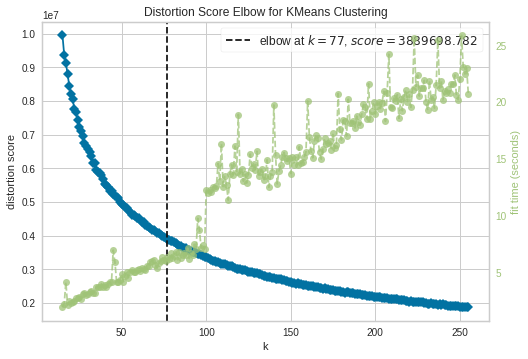

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(min_num_clusters, max_num_clusters),verbose=1)

visualizer.fit(features)    # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 77 #len(articles)//100
max_iter = 300
n_runs = 10

kmeans = KMeans(
    n_clusters=num_clusters, init='random',
    n_init=n_runs, max_iter=max_iter, 
    tol=1e-04, random_state=0
)

y_pred_km = kmeans.fit_predict(np.array(articles))
articles['KMeans-Cate']=y_pred_km

articles = articles.reset_index()
category_tf = articles.groupby(['KMeans-Cate'])['article_id'].apply(list)

# get all the products in the category if the customer once bought product in this category
pred={}
for i, u in enumerate(tqdm(val_cus['customer_id'].unique())):
  if u in transactions['customer_id'].unique():
    cate_no = articles[articles['article_id'].isin((transactions['article_id'][transactions['customer_id']==u]).unique())]['KMeans-Cate'].unique()
    pred[u]=[]
    for j in [category_tf[i] for i in cate_no]:
      pred[u].extend(j)
  else:
    pred[u]=popularity

def calc_map(y_true, y_score, k=None):
    if k is None: k=len(y_score)
    relevant = np.isin(y_score[:k], y_true) # relevant[i]==1 if y_score[i] is correct
    patk = np.cumsum(relevant)/np.arange(1, len(y_score[:k])+1) # patk[0]==P@1, patk[1]==P@2, ...
    return(np.sum(patk*relevant)/min(len(y_true), k)) # as defined by the competition

target = dict(zip(val_cus['customer_id'],val_cus['article_id']))

100%|██████████| 48192/48192 [27:14<00:00, 29.48it/s]


In [ ]:
print(pred.items())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
np.save(f'{data_dir}/tabular_kmeans.npy', pred)

In [ ]:
pred1 = np.load(f'{data_dir}/tabular_kmeans.npy', allow_pickle=True)

In [ ]:
map=0
for u in val_cus['customer_id'].unique():
  map+=calc_map(np.array(target[u]),np.array(pred1.item()[u]),k=12)

map/len(val_cus['customer_id'].unique())

0.0019037665261138518